In [14]:
import joblib
import pandas as pd

from src.evaluation.metrics import regression_metrics
from src.data_utils.loader import DataLoader
from src.utils.logger import setup_logger

from typing import List

In [15]:
# m_aubrey_path = 'src/models/trained/OLS+H_20260211_042014.joblib'
# m_betty_path = "src/models/trained/OLS-3+H_20260212_011913.joblib"
# m_chloe_path = 'src/models/trained/ENet+H_20260211_043105.joblib'
m_debby_path = 'src/models/trained/PCR_20260212_105021.joblib'
# m_####_path = 'src/models/trained/NN1_20260210_033548.joblib'

In [16]:
# Use shared logger but ensure Optuna propagates logs
logger = setup_logger("Evaluator", log_dir="reports/experiments")

class ModelEvaluator:
    def __init__(self, df: pd.DataFrame, target_col='target_ret_excess', date_col='date'):
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col
        
        self.ff3_features = ['mvel1', 'bm', 'mom12m']
        self.unique_dates = sorted(self.df[self.date_col].unique())
        
        # Directories for persistence
        self.model_dir = "src/models/trained"

    def _get_feature_subset(self, feature_set_name: str) -> List[str]:
        if feature_set_name == 'ff3':
            return self.ff3_features
        elif feature_set_name == 'all':
            exclude = {self.target_col, self.date_col, 'date_fmt', 'permno', 'year'}
            return [c for c in self.df.columns if c not in exclude]
        else:
            raise ValueError(f"Unknown feature set: {feature_set_name}")

    def strict_time_split(self, df: pd.DataFrame, test_ratio: float = 0.2):
        """Splits data strictly by time."""
        split_idx = int(len(self.unique_dates) * (1 - test_ratio))
        split_date = self.unique_dates[split_idx]
        
        train_mask = df[self.date_col] < split_date
        test_mask = df[self.date_col] >= split_date
        
        logger.info(f"Time Split: {split_date.date()} | Train: {train_mask.sum()} | Test: {test_mask.sum()}")
        return df.loc[train_mask], df.loc[test_mask]

    def run_eval(self, model_path: str):
        """Orchestrates the full ML Pipeline."""
        logger.info("--- STARTING EVALUATION ---")

        logger.info(f"[+] SPLITTING DATA")
        _, df_test = self.strict_time_split(self.df)

        logger.info(f"[+] LOADING MODEL")
        model = joblib.load(model_path)

        features = model.feature_names_in_
        y_test = df_test[self.target_col]
        df_test['target_pred'] = model.predict(df_test[features])
        y_pred = df_test['target_pred']
        
        metrics = regression_metrics(y_test, y_pred)
        
        return df_test, metrics

In [17]:
gold_panel_path = "data/processed/gold_panel"

loader = DataLoader(data_path = gold_panel_path)
df = loader.load_panel_data()

evaluator = ModelEvaluator(df)
df_test, metrics = evaluator.run_eval(m_debby_path)

[2026-02-12 10:53:56] [INFO] [ParquetLoader] REQ: Loading ALL columns...
[2026-02-12 10:53:56] [INFO] [ParquetLoader] SOURCE: data/processed/gold_panel


[2026-02-12 10:54:23] [INFO] [ParquetLoader] LOAD COMPLETE. Shape: (4065278, 100) | RAM: 1.65 GB
[2026-02-12 10:54:24] [INFO] [Evaluator] --- STARTING EVALUATION ---
[2026-02-12 10:54:24] [INFO] [Evaluator] [+] SPLITTING DATA
[2026-02-12 10:54:24] [INFO] [Evaluator] Time Split: 2008-12-31 | Train: 3172950 | Test: 892328
[2026-02-12 10:54:25] [INFO] [Evaluator] [+] LOADING MODEL


C:\Users\rcorr\AppData\Local\Temp\ipykernel_16316\3922546782.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target_pred'] = model.predict(df_test[features])


In [27]:
metrics

{'rmse': np.float64(0.1748279896980326),
 'r2_sklearn': -0.0023508071899414062,
 'r2_oos': np.float32(0.0031544566)}

In [18]:
df_test

,permno,date,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,...,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,target_ret_excess,mktcap_next,year,target_pred
3172950,10001,2008-12-31,-0.608717,-0.017622,-0.017964,-0.324907,-0.622889,-0.124380,0.928115,-0.039344,...,-0.227645,-0.038651,0.561671,-0.411071,0.813298,49.0,0.034113,3.653309e+01,2008,0.008448
3172951,10002,2008-12-31,0.095199,0.849786,0.849444,0.965285,-0.191343,0.566809,0.805797,0.604590,...,0.823125,0.768097,-0.726454,-0.763184,0.448411,60.0,-0.399051,1.557128e+02,2008,0.003289
3172952,10025,2008-12-31,-0.082746,0.455261,0.454919,0.781598,-0.081161,-0.055945,0.139348,0.775410,...,0.173927,-0.649853,-0.004095,0.051752,-0.052080,30.0,-0.184300,9.713916e+01,2008,0.006323
3172953,10026,2008-12-31,0.418974,-0.204106,-0.204448,0.871250,0.138547,-0.639692,0.344850,0.386557,...,-0.573207,-0.719293,-0.092219,-0.532591,0.221422,20.0,-0.027035,6.403192e+02,2008,0.005321
3172954,10028,2008-12-31,-0.825332,0.952780,0.952438,-0.370408,-0.880308,0.896322,-0.327002,-0.579672,...,0.412709,0.315100,0.718264,-0.768425,0.693744,59.0,-0.191176,1.352175e+01,2008,-0.004166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4065273,93423,2021-11-30,0.532974,0.817430,0.816352,-0.817578,0.662572,0.195328,0.893289,-0.526160,...,0.607803,0.594165,0.235749,0.694461,-0.739991,79.0,0.164242,3.661156e+03,2021,0.004311
4065274,93426,2021-11-30,-0.139322,0.252471,0.248877,0.188537,-0.226284,-0.480323,0.275877,-0.447236,...,-0.513757,-0.463457,-0.256743,-0.577551,0.407774,36.0,0.081170,4.678234e+02,2021,0.004810
4065275,93427,2021-11-30,0.535595,-0.257502,-0.262174,0.106762,0.359183,-0.126685,0.275877,-0.664203,...,-0.521910,-0.078629,-0.190844,-0.220991,0.155336,36.0,0.071445,4.385522e+03,2021,0.003370
4065276,93434,2021-11-30,-0.523366,-0.750943,-0.757053,-0.294077,-0.614622,0.449416,-0.960256,0.990098,...,0.967681,0.946900,0.813384,0.698251,-0.199301,1.0,-0.065169,1.061697e+02,2021,0.002857


In [23]:
df_eval = df_test[['date', 'target_ret_excess', 'target_pred']]
df_eval

,date,target_ret_excess,target_pred
3172950,2008-12-31,0.034113,0.008448
3172951,2008-12-31,-0.399051,0.003289
3172952,2008-12-31,-0.184300,0.006323
3172953,2008-12-31,-0.027035,0.005321
3172954,2008-12-31,-0.191176,-0.004166
...,...,...,...
4065273,2021-11-30,0.164242,0.004311
4065274,2021-11-30,0.081170,0.004810
4065275,2021-11-30,0.071445,0.003370
4065276,2021-11-30,-0.065169,0.002857


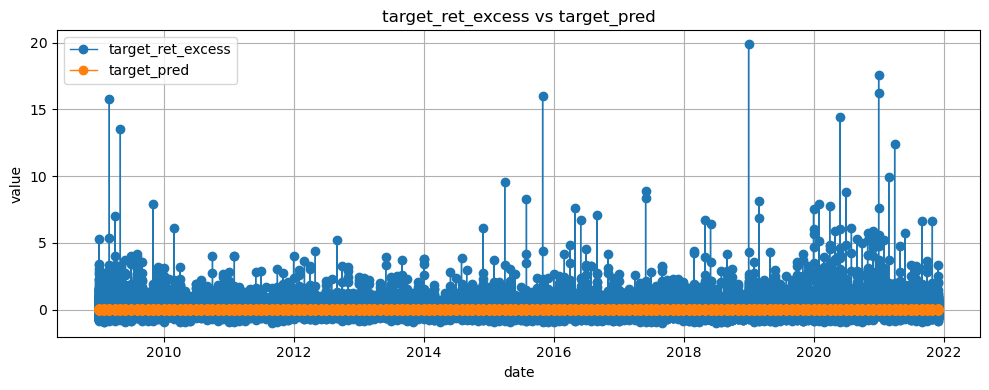

In [24]:
import matplotlib.pyplot as plt

df_plot = df_eval.sort_values('date')

plt.figure(figsize=(10, 4))
plt.plot(df_plot['date'], df_plot['target_ret_excess'], label='target_ret_excess', marker='o', linewidth=1)
plt.plot(df_plot['date'], df_plot['target_pred'], label='target_pred', marker='o', linewidth=1)
plt.xlabel('date')
plt.ylabel('value')
plt.title('target_ret_excess vs target_pred')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

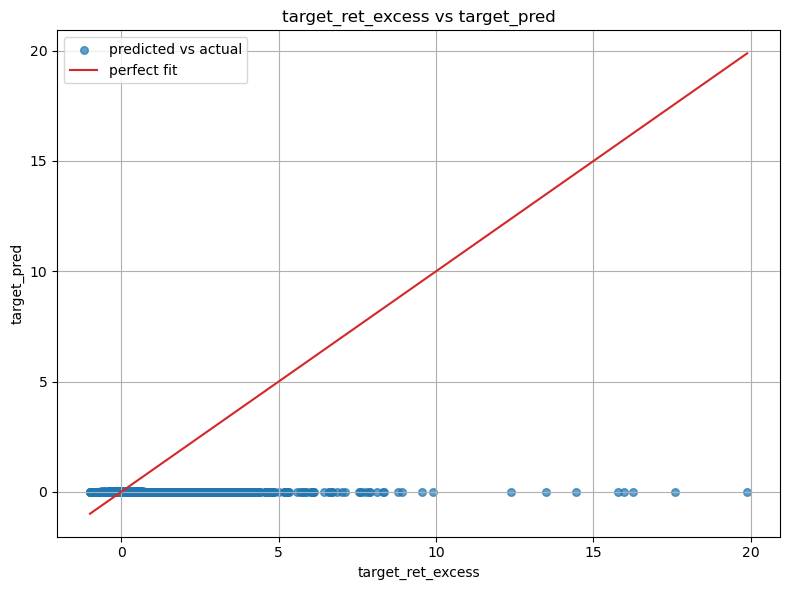

In [25]:
df_plot = df_eval.sort_values('date')

xmin = min(df_plot['target_ret_excess'].min(), df_plot['target_pred'].min())
xmax = max(df_plot['target_ret_excess'].max(), df_plot['target_pred'].max())

plt.figure(figsize=(8, 6))
plt.scatter(df_plot['target_ret_excess'], df_plot['target_pred'],
            color='tab:blue', label='predicted vs actual', s=30, alpha=0.7)
plt.plot([xmin, xmax], [xmin, xmax], color='tab:red', label='perfect fit', linewidth=1.5)
plt.xlabel('target_ret_excess')
plt.ylabel('target_pred')
plt.title('target_ret_excess vs target_pred')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

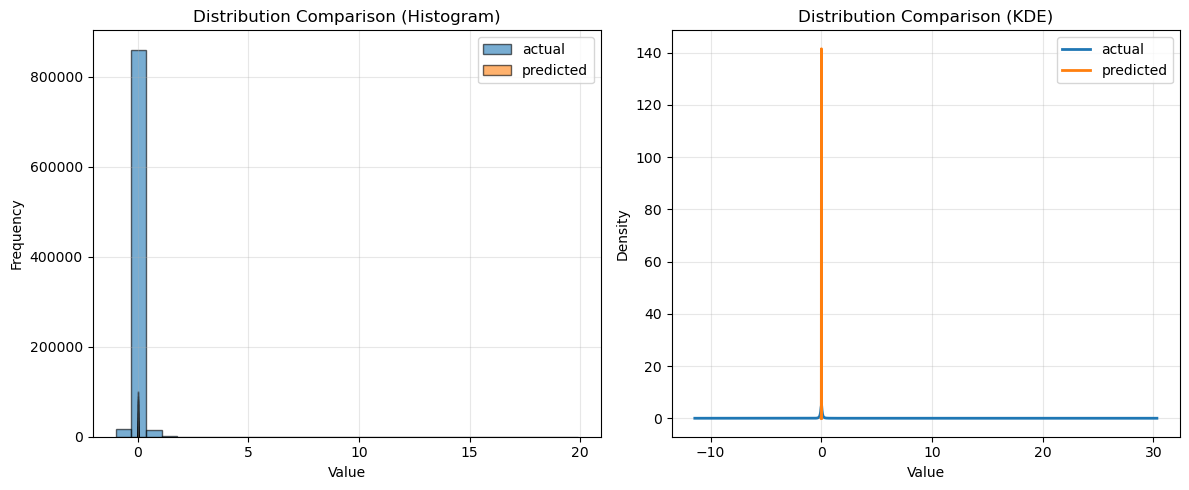

In [26]:
plt.figure(figsize=(12, 5))

# Histogram with overlapping distributions
plt.subplot(1, 2, 1)
plt.hist(df_plot['target_ret_excess'], bins=30, alpha=0.6, label='actual', edgecolor='black')
plt.hist(df_plot['target_pred'], bins=30, alpha=0.6, label='predicted', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Comparison (Histogram)')
plt.legend()
plt.grid(True, alpha=0.3)

# KDE plot for smoother comparison
plt.subplot(1, 2, 2)
df_plot['target_ret_excess'].plot(kind='kde', label='actual', linewidth=2)
df_plot['target_pred'].plot(kind='kde', label='predicted', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison (KDE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()